In [2]:
# Code to evaluate the performance of the classifier layer using NEMO Classifier

# Import Libraries

#from ConfigParser import SafeConfigParser
from PIL import Image, ExifTags

#import pynemo
import multiprocessing
import scipy.ndimage
import numpy as np
%matplotlib inline
from pylab import *
import caffe
#import h5py
import time
import cv2
import os
import csv
import scipy 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

#sys.path.append('utils')
from utils.TrainNet import train, trainXSteps
from utils.Vis import vis_make_palette, vis_color_seg, checkEXIFRotation

# caffe.set_mode_cpu()
# print("CPU mode")

caffe.set_mode_gpu()
caffe.set_device(0)
# caffe.set_mode_cpu()

print("GPU mode")

print('OK')

GPU mode
OK


In [3]:
def get_net(protxt_file, caffemodel_file):
    # This function returns the caffemodel
    return caffe.Net( protxt_file, caffemodel_file, caffe.TEST)

# protxt_file = '/opt/caffe/neurala/training-pipeline/models/FullDenseNet/FullDenseNet-Forward.prototxt'
protxt_file = '/opt/caffe/neurala/training-pipeline/models/classifier/CIFAR_model/architecture_files/signet1024ss-10.prototxt'
# protxt_file = '/opt/caffe/neurala/training-pipeline/models/classifier/classifier_1500/deploy.prototxt'
# caffemodel_file = '/opt/caffe/neurala/training-pipeline/models/weights/snapshot_iter_40000.caffemodel'
caffemodel_file = '/opt/caffe/neurala/training-pipeline/models/classifier/CIFAR_model/CIFAR_caffemodels/signet1024ss-CIFAR-10.caffemodel'
# caffemodel_file = '/opt/caffe/neurala/training-pipeline/models/classifier/classifier_1500/snapshot_iter_1550.caffemodel'

# net = get_net(protxt_file, caffemodel_file)

In [4]:
path = '/opt/caffe/neurala/training-pipeline/models/classifier/CIFAR_dataset/data'

In [5]:
labels = """airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck"""

_classes = {i: v.replace(' ', '_') for i, v in enumerate(labels.split('\n'))}

print(_classes[1])
print(_classes)

automobile
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [6]:
def get_image():
    """
    Function to load image locations, corresponding ground truth classes for classification from test

    return:
    A list with each individual image of the form
    [Image_location in str], [Ground truth of image classification]
    """
    # Reference the directory of the GVDL folder
    img_loc = path + '/test.list'
    data = [] 
    gt = []
    with open(img_loc, 'r') as f:
        reader = csv.reader(f, dialect='excel', delimiter='-')
        for row in reader:
            data.append(path + '/test/' + row[0] + '-' + row[1])
            gt.append(row[1])
    return data, gt

def get_train_image():
    """
    Function to load image locations, corresponding ground truth classes for classification from train

    return:
    A list with each individual image of the form
    [Image_location in str], [Ground truth of image classification]
    """
    # Reference the directory of the GVDL folder
    img_loc = path + '/train.list'
    data = [] 
    gt = []
    with open(img_loc, 'r') as f:
        reader = csv.reader(f, dialect='excel')
        for row in reader:
#             print(row[0])
            data.append(path + '/train/' + row[0])
#             print(row[0].split("-")[2][:-4])
            gt.append(row[0].split("-")[2][:-4])
    return data, gt

In [7]:
def normailize(im_arr):
    range = im_arr.max() - im_arr.min() 
    im_arr = (im_arr - im_arr.min()) / range - 0.5
    return im_arr

def subtract_mean(im_arr):
    # This function was needed for classifier_1500 model which has a great accuracy. It needs mean subtraction
    im_src = '/opt/caffe/neurala/training-pipeline/models/classifier/classifier_1500/image.png'
    im = Image.open(im_src)
    im = np.asarray(im)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    im = np.int32(im)
    im_arr = np.int32(im_arr) 
    temp = (im_arr - im[:,:,0:3])
    return temp


def classifier(protxt_file, caffemodel_file, myImagePath, gt):
#     Get the model ready
    net = get_net(protxt_file, caffemodel_file)
#     print("loaded the net successfully")
    im = Image.open(myImagePath)
    im_arr = np.asarray(im)
    
#     We need to rotate the image by 90 degrees
    h,w,_ = np.shape(im_arr)
    center = (w / 2, h / 2) 
    M = cv2.getRotationMatrix2D(center, 90, 1) 
    im_arr = cv2.warpAffine(im_arr, M, (h, w)) 
    
#     fig1,ax1 = plt.subplots(1)
#     ax1.imshow(im_arr)
    
    im_arr = cv2.cvtColor(im_arr, cv2.COLOR_RGB2BGR)
#     im_arr = cv2.flip( im_arr, 0)  # Use this to flip images

#     fig1,ax1 = plt.subplots(1)
#     ax1.imshow(im_arr)
#     im_arr = subtract_mean(im_arr) # use this for classifier_1500
    
    im_arr = normailize(im_arr)      # Needed for Signet-1024ss

    im_data = im_arr.transpose((2,1,0))
#     print("The shape of im_data is ", np.shape(im_data))
    img_list = []
    img_list.append(im_data)
#     print("The shape of img_list is ", np.shape(img_list))
    net.blobs['data'].reshape(*np.asarray(img_list).shape)
    net.blobs['data'].data[...] = img_list
    net.forward()
    class_output = net.blobs['softmax'].data
    return class_output

In [29]:
data,gt = get_image()
# data,gt = get_train_image()
print(len(data))


# Feed in the index of the image you want to evaluate
index = 15
pred = classifier(protxt_file, caffemodel_file, data[index], gt[index])
# print(pred)
li = pred[0]
pos = np.argmax(li)
# print(np.argmax(li))
print("The predicted class is", _classes[np.argmax(li)])
print("The True class is", gt[index][:-4])  # For testing
# print("The True class is", gt[index])    # For training

10000
The predicted class is automobile
The True class is automobile


In [11]:
count = 0
if (_classes[np.argmax(li)] == gt[index][:-4]):
    print("1")
    
# for training
if (_classes[np.argmax(li)] == gt[index]):
    print("1")

1


In [12]:
def evaluate():
    score = 0
    data,gt = get_image()
    correct_class = []
    wrong_class_gt = []
    wrong_class_pred = []
#     data,gt = get_train_image()
    for index in range(0,len(data)-9700):
        if (index%100==1):
            print("The accuracy at index",index-1,"is", score/index * 100, "%")
        pred = classifier(protxt_file, caffemodel_file, data[index], gt[index])
        li = pred[0]
        if (_classes[np.argmax(li)] == gt[index][:-4]):   # For test images
#         if (_classes[np.argmax(li)] == gt[index]):          # For train images
            correct_class.append(_classes[np.argmax(li)])
            score+=1
#             print(_classes[np.argmax(li)], index)
        else:
            wrong_class_gt.append(gt[index][:-4])
            wrong_class_pred.append(_classes[np.argmax(li)])
    return score, wrong_class_gt, wrong_class_pred, correct_class

In [13]:
ams, wrong_gt, wrong_pred, correct_pred = evaluate()

The accuracy at index 0 is 100.0 %
The accuracy at index 100 is 84.15841584158416 %
The accuracy at index 200 is 84.5771144278607 %


In [28]:
True_Positive = {x:correct_pred.count(x) for x in sorted(correct_pred)}
False_Positive = {x:wrong_pred.count(x) for x in sorted(wrong_pred)}
# print(True_Positive)
# print(False_Positive)
# print(True_Positive.values())
# print(False_Positive.values())
TP_keys = np.fromiter(True_Positive.values(), dtype=int)
FP_keys = np.fromiter(False_Positive.values(), dtype=int)
# print(TP_keys)
# print(FP_keys)
prec = np.asarray([TP_keys[i]/(TP_keys[i] + FP_keys[i]) for i in range(len(TP_keys))])
print("The Mean Precision is", np.mean(prec))
# print(prec)

The Mean Precision is 0.8438900976400976


In [21]:
import pandas
from collections import Counter
def plot_graph(a, title2):
    class_count = Counter(a)
    df = pandas.DataFrame.from_dict(class_count, orient='index')
    df.plot(kind='bar', title = title2)
    df.title = title

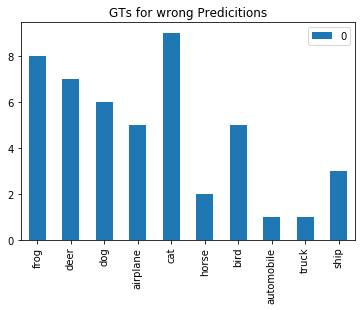

In [23]:
plot_graph(wrong_gt, "GTs for wrong Predicitions")

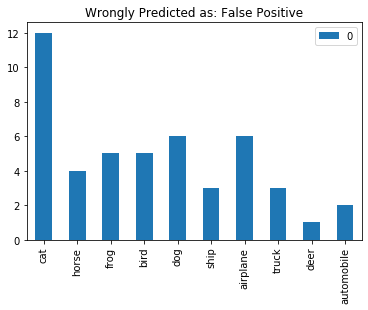

In [24]:
plot_graph(wrong_pred, "Wrongly Predicted as: False Positive")

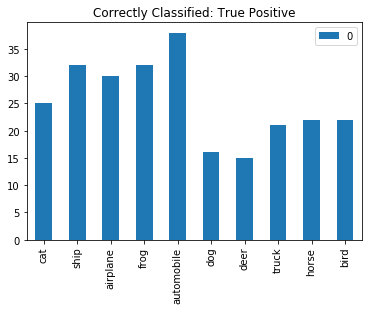

In [25]:
plot_graph(correct_pred, "Correctly Classified: True Positive")

In [26]:
# SDK Calculation
sdk = np.array([0.822,0.885,0.855, 0.817, 0.947, 0, 0.75, 0.714, 0.756, 0.781])
print(np.mean(sdk))

0.7326999999999999
